# Предобработка данных и функции потерь в линейной регрессии

## Данные
На семинаре мы будем работать с набором данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки.

In [68]:
import pandas as pd
X_raw = pd.read_csv("cars.csv", header=None, na_values=["?"])

In [69]:
X_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495.1
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500.0
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950.0
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450.0


## Предобработка данных
Предобработка данных важна при применении любых методов машинного обучения, а в особенности для линейных моделей. В sklearn предобработку удобно делать с помощью модуля [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)

In [29]:
from sklearn import preprocessing

### Преобразование нечисловых признаков
Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам. 

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

Это пример категориального признака, принимающего значения из неупорядоченного конечного множества $K$. К таким признакам обычно применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). В sklearn это можно сделать следующим образом:

In [70]:
# для удосбства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values # категориальные признаки имеют тип "object"

In [72]:
# кодирование категорий-строк натуральными числами
label_enc = preprocessing.LabelEncoder()
for feature in X_raw.columns[cat_features_mask]: 
    X_raw[feature] = label_enc.fit_transform(X_raw[feature])

In [73]:
X_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,0,1,0,2,0,2,0,88.6,...,130,5,3.47,2.68,9,111,5000,21,27,13495.1
1,3,NaN,0,1,0,2,0,2,0,88.6,...,130,5,3.47,2.68,9,111,5000,21,27,16500.0
2,1,NaN,0,1,0,2,2,2,0,94.5,...,152,5,2.68,3.47,9,154,5000,19,26,16500.0
3,2,164,1,1,0,1,3,1,0,99.8,...,109,5,3.19,3.40,10,102,5500,24,30,13950.0
4,2,164,1,1,0,1,3,0,0,99.4,...,136,5,3.19,3.40,8,115,5500,18,22,17450.0


In [164]:
# применение one-hot ecnoding
enc = preprocessing.OneHotEncoder(sparse=False)
X_cat_np = enc.fit_transform(X_raw[X_raw.columns[cat_features_mask]])
X_cat_pd = pd.DataFrame(data=X_cat_np)

In [166]:
print X_cat_pd.shape
X_cat_pd.head()

(201, 60)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Следует заметить, что в новой матрице очень много нулевых значений. Чтобы не хранить их в памяти, можно задать параметр OneHotEncoder(sparse = True), и метод fit_transform вернет [разреженную матрицу](http://docs.scipy.org/doc/scipy/reference/sparse.html), в которой хранятся только ненулевые значения. Выполнение некоторых операций с такой матрицей может быть неэффективным, однако большинство методов sklearn умеют работать с разреженными матрицами.

__Вопрос:__ какая проблема возникнет при применении такого способа кодирования для обучения линейной регрессии?
    
Необходимо удалить один из столбцов, созданных для каждого признака (его легко вычислить из остальных):

In [168]:
X_cat_pd.drop(enc.feature_indices_[:-1], axis=1, inplace=True)

Помимо категориальных, преобразования требуют, например, строковые признаки. Их можно превращать в матрицу частот слов [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), матрицу частот буквосочетаний фиксированной длины, можно извлекать другие признаки (например, длина строки).

### Заполнение пропусков
В матрице объекты-признаки могут быть пропущенные значения, и это вызовет исключение при попытке передать такую матрицу в функцию обучения модели. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно разными способами:
* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Замена пропусков средними в вещественных признаках:

In [172]:
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = preprocessing.Imputer(strategy="mean")
X_no_mis = pd.DataFrame(data=mis_replacer.fit_transform(X_real))

In [173]:
X_no_mis.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,3,122,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9,111,5000,21,27,13495.1
1,3,122,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9,111,5000,21,27,16500.0
2,1,122,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9,154,5000,19,26,16500.0
3,2,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10,102,5500,24,30,13950.0
4,2,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8,115,5500,18,22,17450.0


Всегда нужно осознавать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению. В наши данных пропусков в категориальных признаках нет.

In [174]:
# проверка пропусков в категориальных признаках
np.any(np.isnan(X_cat_num))

False

In [175]:
# проверка пропусков после применения Imputer
np.any(X_no_mis.isnull())

False

### Масштабирование признаков
При начале работы с данными всегда рекомендуется приводить все признаки к одному масштабу.  Это важно по нескольким причинам:
* ускорение обучения модели (пояснение на лекции);
* улучшение численной устойчивости при работе с матрицей объекты-признаки (рядом с нулем чисел с плавающей точкой больше, чем с области больших чисел)
* для линейных моделей: интерпретация весов при признаках как меры их значимости.

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение. Реализация в sklearn (нормировать бинарные признаки не нужно):

In [181]:
normalizer = preprocessing.StandardScaler()
X_real_norm_np = normalizer.fit_transform(X_no_mis)
X_real_norm_pd = pd.DataFrame(data=X_real_norm_np)

Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения. Реализация в sklearn:

In [179]:
mm_scaler = preprocessing.MinMaxScaler()
X_mm_scaled = mm_scaler.fit_transform(X_no_mis)

Объдиняем категориальные и вещественные признаки:

In [355]:
X = pd.concat([X_real_norm_pd, X_cat_pd], axis=1)
X.columns = np.array(["f"+str(i) for i in range(X.shape[1])])

In [356]:
X.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65
0,1.725050,0.000000,-1.685107,-0.439409,-0.853460,-2.034081,-0.014858,0.075389,0.520894,-1.829927,...,0,0,0,0,0,0,0,1,0,0
1,1.725050,0.000000,-1.685107,-0.439409,-0.853460,-2.034081,-0.014858,0.075389,0.520894,-1.829927,...,0,0,0,0,0,0,0,1,0,0
2,0.127193,0.000000,-0.710103,-0.244152,-0.185597,-0.559713,0.518080,0.606234,-2.433435,0.675938,...,0,0,0,0,0,0,0,1,0,0
3,0.926121,1.315931,0.165748,0.195176,0.148335,0.218425,-0.423766,-0.431327,-0.526210,0.453899,...,0,0,0,0,0,0,0,1,0,0
4,0.926121,1.315931,0.099646,0.195176,0.243744,0.218425,0.520017,0.220165,-0.526210,0.453899,...,0,0,0,0,0,0,0,1,0,0


### Добавление полиномиальных признаков
Генерировать все полиномиальные признаки можно следующим образом:

In [400]:
pol_feat = preprocessing.PolynomialFeatures(include_bias=False) # не включать константный признак
X_pol = pol_feat.fit_transform(X)

In [402]:
X.shape, X_pol.shape

((201, 66), (201L, 2277L))

Обратите внимание, что новая матрциа может занимать очень много памяти. Генерация полиномиальных признаков нужна, например, в случае, если вы хотите с помощью линейной регрессии настраивать полиномиальную модель зависимости целевого признака от данных.

## Функции потерь в регрессии

Функционал качества в задачах обучения с учителем обычно задается в виде суммы по объектам выборки:
$$Q(a) = \sum_{i=1}^\ell L(y_i, a(x_i)),$$
где $L(\cdot, \cdot)$ - функция потерь, задающая штраф за разницу между предсказанием и истинным значением целевого признака. Свойства функции потерь:
* $L(y_i, a(x_i)) \geqslant 0$;
* $L(y_i, y_i) = 0$. 

Как отмечалось на первой лекции, функционал качества должен в первую очередь отвечать требованиям заказчика, при этом математические свойства функции потерь могут быть неудобны для оптимизации. 

__Пример:__ если мы не различаем маленькие ошибки (между 0.01 и 0.1 нет особой разницы), но зато не хотим получать большие ошибки, можно использовать следующую функцию потерь:

$$L(y_i, a(x_i)) = [| y_i - a(x_i) | < \varepsilon],$$ $\varepsilon$ - допустимая разница между предсказанием и фактом.


### Среднеквадратичная и средняя абсолютная ошибка
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели, например устойчивость к шумовым объектам. В линейной регрессии Mean Squared Error: $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не облаадет этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения. 

Рассмотрим это явление на примере. Выберем один признак, от которого целевой признак (имеющий индекс 15 в матрице X) зависит практически линейно. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимизированная на MSE прямая.

In [249]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as LR

In [264]:
X_subset = X[["f7", "f15"]].values
X_subset_modified = np.vstack((X_subset, [[1, 90], [2, 50]])) # добавление двух шумовых точек

In [279]:
def scatter_points_and_plot_line_MSE(X_subset):
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    lr = LR()
    lr.fit(X_subset[:, 0][:, np.newaxis], X_subset[:, 1])  # найдем веса линейной модели
    grid = np.linspace(-2, 6, 100)
    line = lr.predict(grid[:, np.newaxis])
    plt.plot(grid, line)   # визуализируем прямую

(-20, 100)

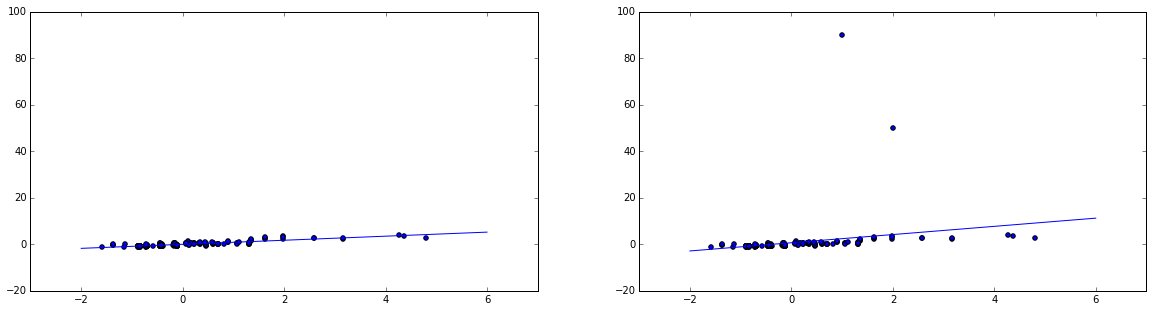

In [382]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
scatter_points_and_plot_line_MSE(X_subset)
plt.ylim(-20, 100)
plt.subplot(1, 2, 2)
scatter_points_and_plot_line_MSE(X_subset_modified)
plt.ylim(-20, 100)

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE часто используют Mean Absoulte Error: $L(y_i, a(x_i)) = |a(x_i) - y_i|$:

Теперь обучим регрессию, оптимизируя MAE. В sklearn такая регрессия не реализована, но можно использовать модуль statmodels

In [243]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [289]:
def scatter_points_and_plot_line_MAE(X_subset):
    mod = smf.quantreg('f15 ~ f7', pd.DataFrame(data=X_subset, columns=["f7", "f15"])) # задаеем зависимость и передаем данные
    res = mod.fit(q=0.5)
    plt.scatter(X_subset[:, 0], X_subset[:, 1])   # визуализируем точки
    grid = np.linspace(-2, 6, 100)
    plt.plot(grid, grid * res.params["f7"] + res.params["Intercept"])   # визуализируем прямую
    return mod, res

(-20, 100)

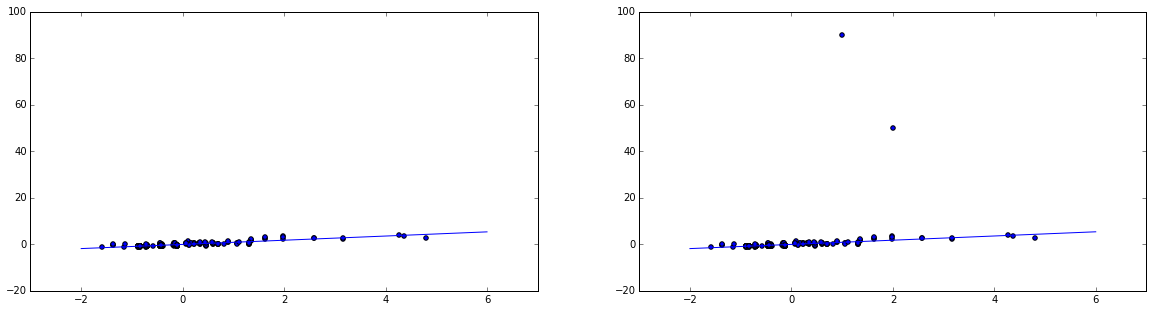

In [383]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified)
plt.ylim(-20, 100)

Прямая не изменила напраление из-за выборосов.

Попробуем добавить больше шумовых объектов:

In [396]:
X_subset_modified_twice = np.vstack((X_subset_modified, np.random.randint(5, size=60).reshape(-1, 2)*[1, 30])) # добавление двух шумовых точек

(-20, 100)

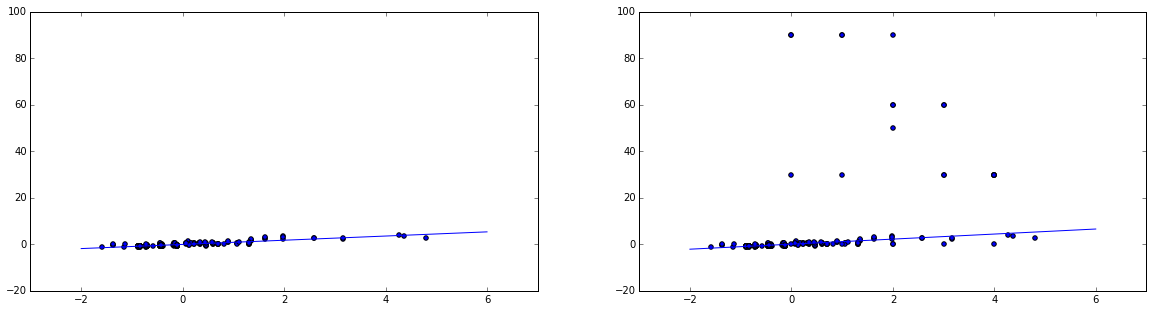

In [397]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified_twice)
plt.ylim(-20, 100)

Прямая немного изменила наклон, когда мы добавили 30 (почти 15%) шумовых точек.

Рассмотрим некоторые свойства MSE и MAE.

Пусть алгоритм возвращает константный ответ: $a(x) = C$. Такие алгоритмы используются, когда для одного объекта известны несколько различных значений одного целевого признака (например, суммы покупок в одном магазине).

__Задача.__ Найдите $C$, минимизирующий среднеквадратичную ошибку.

_Решение._ $$MSE(C) = \sum_{i=1}^\ell (C - y_i)^2$$
$$\frac{\partial MSE (C)}{\partial C} = \sum_{i=1}^\ell 2 (C - y_i) = 2 C \ell - \sum_{i=1}^\ell 2 y_i = 0$$
$$c = \frac 1 \ell \sum_{i=1}^\ell y_i$$.

__Задача.__ Найдите $C$, минимизирующий среднюю абсолютную ошибку.

_Решение._ $$MAE(C) =  \sum_{i=1}^\ell |C - y_i|$$

Покажем, что минимум MAE достигается при $C = median(y_1, \dots, y_\ell) = m.$ Рассмотрим $C < m$.

$$|y_i - C| - |y_i - m| = \begin{cases} C - m, y_i < m  \\ C + m - 2 y_i, C \leqslant y_i \leqslant m \\ - (C - m), y_i > m \end{cases}$$
$$|y_i - C| - |y_i - m| \geqslant - (C - m) + 2(C - m) [x_i \leqslant m]$$
Суммируем по i:
$$\ell MAE(C) - \ell MAE(m) \geqslant - \ell (C - m) + 2 (C - m) \sum_{i=1}^\ell [x_i \leqslant m]$$

Так как m - медиана, $\sum_{i=1}^\ell [x_i \leqslant m] \geqslant \frac \ell 2$. Тогда

$$\ell MAE(C) - \ell MAE(m) \geqslant - \ell (C - m) + 2 (C - m) \frac \ell 2 = 0.$$

Итак, для $C < m$ $MAE(C) \geqslant MAE(m)$. Аналогично показывается, что при для $C > m$ $MAE(C) \geqslant MAE(m)$.

Поскольку средняя абсолютная ошибка не является дифференцируемой по $w$ функцией, оптимизировать ее напрямую методом градиентного спуска не удастся. Для этого используются субградиентные или другие методы. Один из способов оптимизации MAE будет рассмотрен ниже.

### Huber Loss
Иногда используют "гибрид" MAE и MSE, который, как и MAE, устойчив к шумовым объектам, и как и MSE, мало штрафует малые отклонения от фактического значени целевого признака - Huber Loss:
$$L(y_i, a(x_i)) = \begin{cases} \frac 1 2(a(x_i) - y_i)^2, - \epsilon < a(x_i) - y_i < \varepsilon, \\|a(x_i) - y_i|, otherwise \\ \end{cases}$$

Легко проверить, что у этой функции существует непрерывная первая проиводна во всех точках.

Оптимизация Huber Loss реализована в sklearn:

In [ ]:
from sklearn.linear_model import HuberRegressor

### Quantile Loss

В некоторых задачах штраф за ошибку зависит не только от величины абсолютного отклонения от фактического значения, но и от знака этого отклонения. Например, лучше предсказать спрос больше, чем будет по факту, чем меньше, потому что в первом случае будет потеряна прибыль. В этом случае используется квантильная регрессия со следующей функцией потерь:
$$L(y_i, a(x_i)) = \rho_\tau(y_i - x_i^T w),$$
$$\rho_\tau(x) = \begin{cases} \tau x, \quad x > 0, \\ (\tau - 1) x, \quad x \leqslant 0 \end{cases}$$
Параметр $\tau$ влияет на то, насколько различаются штрафы за положительную и отрицательную разницу.

Изобразим график квантильной функции потерь вместе с другими рассмотренными:

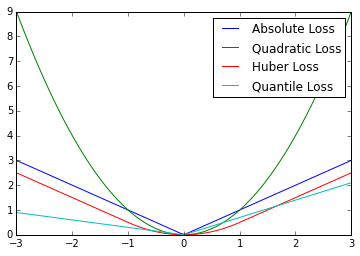

In [417]:
grid = np.linspace(-3, 3, 100)
quantile_tau = 0.7
mse_loss = grid ** 2
quantile_loss = np.abs(grid)
huber_loss = 0.5 * mse_loss * (grid >= -1) * (grid <= 1) + (mae_loss - 0.5) * (grid < -1) + (mae_loss - 0.5)  * (grid > 1)
quantile_loss = quantile_tau * grid * (grid > 0) + (quantile_tau - 1) * grid * (grid <= 0)
plt.plot(grid, mae_loss, label="Absolute Loss")
plt.plot(grid, mse_loss, label="Quadratic Loss")
plt.plot(grid, huber_loss, label="Huber Loss")
plt.plot(grid, quantile_loss, label="Quantile Loss")
plt.legend()

__Задача.__ Укажите параметр $\tau$, при котором обучение квантильной регресси равносильно оптимизации MAE.

_Решение._ При $\tau = \frac 1 2$ $$\rho_\tau(x) = \frac 1 2 |x|$$ и $L(y_i, a(x_i)) = \frac 1 2 MAE$.

#### Обучение квантильной регрессии как задача линейного программирования
Как и в случае с MAE, функция потерь не дифференцируема в 0. Однако задачу оптимизации MAE можно свести к задаче линейного программирования, для которой известны эффективные алгоритмы решения ([Симплекс-метод](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BC%D0%BF%D0%BB%D0%B5%D0%BA%D1%81-%D0%BC%D0%B5%D1%82%D0%BE%D0%B4)). Задача линейного программирования в общем виде задается  следующем виде:
$$\langle c, x \rangle \rightarrow \min_{x}$$
$$Ax = b$$
$$x \geqslant 0$$

__Задача.__ Рассмотрим задачу оптимизации $$\sum_{i=1}^\ell \rho_\tau(y_i - x_i^T w) \rightarrow \min _{w}.$$
Сведите эту задачу к задаче линейного программирования.

_Решение._ Введем переменные:
$$e_i = y_i - x_i^T w$$
$$u_i = max\{e_i, 0\} \geqslant 0$$
$$v_i = max\{-e_i, 0\} \geqslant 0$$
Тогда $u_i - v_i = e_i$,

$$ \rho_\tau(y_i - x_i^T w) = \rho_\tau(e_i) = \rho_\tau(u_i - v_i) = \tau u_i + (1 - \tau) v_i. $$
Последний переход можно проверить непосрдственно. Например, если $e_i \geqslant 0$, то $v_i = 0$,
$$\rho_\tau(e_i) = \tau (u_i - v_i) = \tau (u_i - v_i) + v_i = \tau u_i + (1 - \tau) v_i.$$ Аналогично при $e_i < 0$.

Функционал качества:
$$\sum_{i=1}^\ell \rho_\tau(y_i - x_i^T w) = \sum_{i=1}^\ell \bigl (\tau u_i + (1 - \tau) v_i \bigr) = \tau \sum_{i=1}^\ell u_i + (1 - \tau) \sum_{i=1}^\ell v_i = \tau \langle 1, u \rangle + (1 - \tau) \langle 1, v \rangle ,$$
$1 = (1, \dots, 1) \in R^\ell$, $u = (u_1, \dots, u_\ell$), $v = (v_1, \dots, v_\ell)$.

Задача линейного программирования:

$$\tau \langle 1, u \rangle + (1 - \tau) \langle 1, v \rangle \rightarrow \min_{u, v, w}$$
$$y - X w = u - v$$
$$u \geqslant 0, \quad v \geqslant 0$$

Проследим наклон прямой в нашей одномерной задаче регрессии при изменении $\tau$:

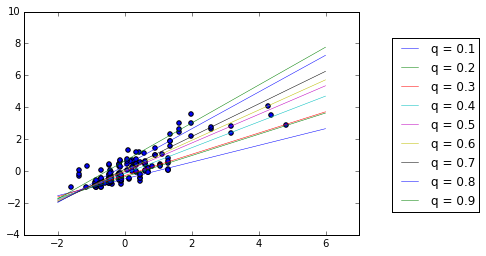

In [413]:
plt.scatter(X_subset[:, 0], X_subset[:, 1])
grid = np.linspace(-2, 6, 100)
mod = smf.quantreg('f15 ~ f7', pd.DataFrame(data=X_subset, columns=["f7", "f15"]))
for q in np.arange(0.1, 1, 0.1):
    res = mod.fit(q=q)
    plt.plot(grid, grid * res.params["f7"] + res.params["Intercept"], linewidth=0.5, label="q = "+str(q))
plt.legend(loc=(1.1, 0.1))

## Vowpal wabbit
Мы увидели, что в python для оптимизации разных функционалов качества приходится искать отдельные модули. Кроме того, для очень больших матриц объекты-признаки python-методы могут быть неэффективны. В сообществе специалистов по машинному обучению популярна система [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki), позволяющая оптимизировать разные функции потерь и предоставляющая пользователю интерфейс для коммандной строки.

В vowpal wabbit реализован эффективный и масштабируемый онлайн-алгоритм для оптимизации линейной модели.

[Входные данные](https://github.com/JohnLangford/vowpal_wabbit/wiki/Input-format) должны быть представлены с виде текстового файла, каждая строка - отдельный объект. Формат строки:

      [Label] [Importance] [Base] [Tag]|Namespace Features |Namespace Features ... |Namespace Features
где
* Label - значение целевого признака
* Importance - вес объекта в функционале качества (коэффициент, на который домножается функция потерь)
* Tag - идентификатор
* Namespace задает группу признаков (пространство имен)
* Признаки перечисляются через пробел в виде признак:значение, :1 можно опускать (если какой-то признак в одном пространстве имен повторяется, то его значения суммируются)

Интерфейс коммандной строки подробно описан на [Github-Wiki проекта](https://github.com/JohnLangford/vowpal_wabbit/wiki/Command-line-arguments).



Данные в указанном формате нужно сохранить в файл (назовем его my_data.txt)

In [379]:
# функция для записи датафрейма в vowpal wabbit
def convert_df_to_vw(df, target_col, vw_path):
    target = df[target_col]
    feature_cols = df.columns.drop(target_col)
    with open(vw_path, "w") as fout:
        for idx in df.index:
            fout.write(str(target[idx])+" |features")
            features = df[feature_cols].loc[idx]
            for feature in features.index:
                if features[feature] != 0:
                    fout.write(" "+str(feature)+":"+str(features[feature]))
            fout.write("\n")

In [381]:
convert_df_to_vw(X, "f15", "my_data.txt")

Пример запуска обучения регрессии на MAE vowpal wabbit с сохранением обученной модели в model.vw (! в начале строки сообщает,  что это команда для коммандной строки):

In [ ]:
! vw --data my_data.txt --loss_function quantile --quantile_tau 0.5 -f model.vw

Другие полезные опции:
* --passes 10 : число проходов по данным во время обучения
* --quadratic ab: сгенерировать квадратичные признаки для пар признаков, один из которых из namespace, начинающегося с a, а другий с b
* --cubic ab : кубические признаки
* --ignore a : игнорироватьпризнаки из namespace, начинающихся с a
* --keep ab : использовать только признаки из namespace, начинающихся с a и b
* --l1 1.0 : коэффииент при L1-регуляризаторе
* --l2 1.0 : коэффициент при L2-регуляризаторе
* --minibatch 5 : число объектов в мини-батче при обучении

Сделать предсказания для новых объектов (в my_test.txt):

In [ ]:
!`vw --data my_test.txt -t -i model.vw --loss_function quantile --quantile_tau 0.5 -r raw_predictions.txt`